In [1]:
#Imports
%matplotlib widget
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import proj3d
import os
import sys
import shutil
from pc2graph import shortpath as sh
import networkx as nx
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits import mplot3d
import scipy.sparse
from tqdm import tqdm
import math

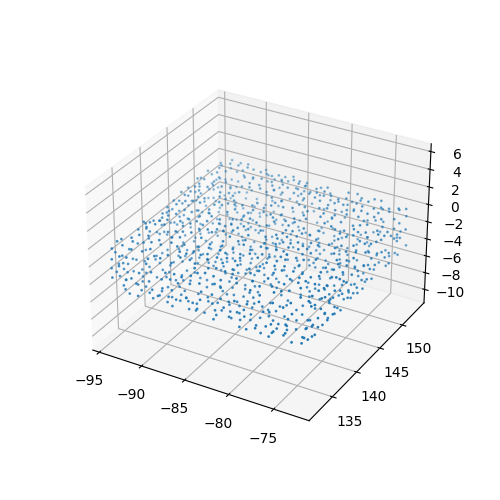

In [3]:
#Visualise model
#data = np.load('../Data/pointclouds/95807.npy')
data = np.load('../Data/sampled_pointclouds/pointclouds_1000/95807.npy')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=1)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [47]:
# Loads point cloud into a numpy.ndarray (n_points x dimensions).
#point_cloud = np.loadtxt('../Data/point_cloud_example.txt').reshape(-1,3)
#point_cloud = np.load('../Data/pointclouds/32770.npy').reshape(-1,3)
point_cloud = np.load('../Data/sampled_pointclouds/pointclouds_1000/95807.npy').reshape(-1,3)

# Growth factor. Each point adds 3 new points to graph.
kpairs = 4

# NN search of the whole point cloud. This allocates knn indices
# for each point in order to grow the graph. The more segmented (gaps)
# the cloud is, the larger knn has to be.
knn = 100

# Maximum distance between points. If distance > threshold, neighboring
# point is not added to graph.
nbrs_threshold = 1

# When initial growth process is broken (gap in the cloud) and no
# other point can be added, incease threshold to include missing points.
nbrs_threshold_step = 0.02

# Base/root point of the point cloud.
base_point = np.argmin(point_cloud[:, 2])

# Generates graph from numpy array.
G = sh.array_to_graph(point_cloud, base_point, kpairs, knn, nbrs_threshold,
                      nbrs_threshold_step)

#nx.write_edgelist(G, 'testedge.txt')
#nx.write_adjlist(G, 'testadj.txt')
sparse = nx.adjacency_matrix(G, nodelist=np.arange(0,point_cloud[:,0].size,1))
scipy.sparse.save_npz('sparse_matrix.npz', sparse)


In [48]:
gn = nx.convert_node_labels_to_integers(G)
G.edges()
points = list(G.nodes)
edges = list(G.edges)
len(edges)

1988

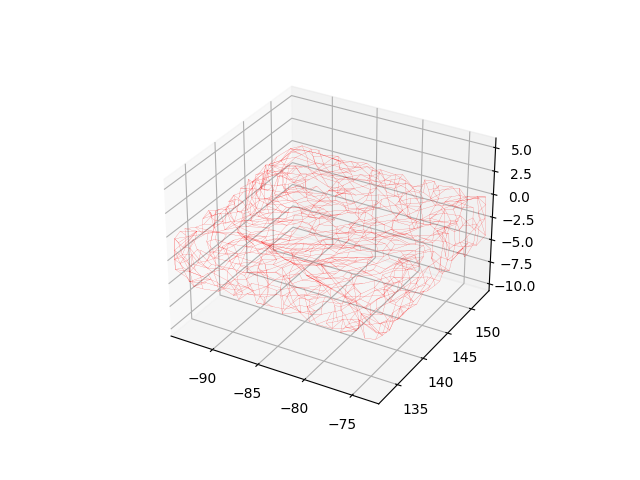

In [49]:
#Plot edges
lc = Line3DCollection(point_cloud[edges], color='r', linewidths=0.1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.add_collection3d(lc)
ax.axes.set_xlim3d(point_cloud[:,0].min(), point_cloud[:,0].max()) 
ax.axes.set_ylim3d(point_cloud[:,1].min(), point_cloud[:,1].max()) 
ax.axes.set_zlim3d(point_cloud[:,2].min(), point_cloud[:,2].max())
ax.set_aspect('equal', adjustable='box')

#Plot points
#ax.plot3D(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2],"o")

In [11]:
features['model_name']

0       472135
1       237632
2        98021
3        97474
4        50881
         ...  
3656    472138
3657     40447
3658    557384
3659    188505
3660    162862
Name: model_name, Length: 3661, dtype: int64

In [19]:
#Preprocess all
kpairs = 4
knn = 100 #20 voor 1000 points,80 voor 5000
nbrs_threshold = 2 #0.04
nbrs_threshold_step = 0.02
path = '../Data/sampled_pointclouds/pointclouds_5000/'
features = pd.read_csv('thingi10k_data.csv', index_col=0)

dest = '../Tests/graphdata/5000clouds/adjacency/'

files = os.listdir(path)
for file in tqdm(files):
    filesh = file.split('.')[0]
    if((int(filesh) in features['model_name'].unique()) and (not os.path.isfile(dest + file))):

        point_cloud = np.load(path + file).reshape(-1,3)

        base_point = np.argmin(point_cloud[:, 2])
        G = sh.array_to_graph(point_cloud, base_point, kpairs, knn, nbrs_threshold,
                            nbrs_threshold_step)
        edges = list(G.edges)
        sparse = nx.adjacency_matrix(G, nodelist=np.arange(0,point_cloud[:,0].size,1))
        
        scipy.sparse.save_npz(f'../Tests/graphdata/5000clouds/adjacency/{filesh}', sparse)

        #Make edgematrix
        edgefeats = scipy.sparse.lil_matrix((point_cloud.shape[0], point_cloud.shape[0]))
        for tuple in edges:
            dist = math.dist(point_cloud[tuple[0]],point_cloud[tuple[1]])
            edgefeats[tuple[0],tuple[1]] = dist
            edgefeats[tuple[1],tuple[0]] = dist
        edgefeats = edgefeats.tocsr()
        scipy.sparse.save_npz(f'../Tests/graphdata/5000clouds/edgefeatures/{filesh}', edgefeats)



100%|██████████| 4268/4268 [29:34<00:00,  2.41it/s] 
